In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# No LabelEncoder here as we will use One-Hot Encoding (pd.get_dummies) later, which is generally safer for nominal categories.

# Load the original dataset
df = pd.read_csv('car data.csv')

print("--- Initial Data Loading and Filtering ---")
print(f"Original dataset shape: {df.shape}")

# Define keywords that indicate a non-car vehicle (e.g., bikes, scooters)
# This list can be expanded if more non-car vehicle names are discovered during EDA.
non_car_keywords = [
    'bike', 'scooty', 'scooter', 'tvs', 'bajaj', 'hero', 'honda activa', 'ktm',
    'royal enfield', 'yamaha', 'pulsar', 'platina', 'splendor', 'passion pro',
    'shine', 'fz', 'apache', 'duke', 'classic 350', 'thunderbird', 'mojo',
    'hyosung', 'um renegade', 'suzuki access 125' # Added as per previous discussion/potential discovery
]

# Create a boolean mask to identify rows that are likely non-cars
# We convert Car_Name to lowercase for case-insensitive matching.
is_non_car = df['Car_Name'].str.lower().apply(lambda x: any(keyword in x for keyword in non_car_keywords))

# Filter the DataFrame to keep only car entries
df = df[~is_non_car].copy() # .copy() to avoid SettingWithCopyWarning later

print(f"Number of non-car entries identified and removed: {is_non_car.sum()}")
print(f"New dataset shape (cars only): {df.shape}")

# Display the first few rows of the filtered dataset
print("\nFirst 5 rows of the filtered (cars only) dataset:")
print(df.head())

# Get a concise summary of the DataFrame (data types, non-null counts)
print("\nInformation about the filtered dataset:")
print(df.info())

# Generate descriptive statistics for numerical columns
print("\nDescriptive statistics of numerical columns for filtered dataset:")
print(df.describe())

--- Initial Data Loading and Filtering ---
Original dataset shape: (301, 9)
Number of non-car entries identified and removed: 86
New dataset shape (cars only): (215, 9)

First 5 rows of the filtered (cars only) dataset:
  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Selling_type Transmission  Owner  
0       Dealer       Manual      0  
1       Dealer       Manual      0  
2       Dealer       Manual      0  
3       Dealer       Manual      0  
4       Dealer       Manual      0  

Information about the filtered dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 215 entries, 0 to 300
Data columns (tot

In [4]:
# EDA and Feature Engineering (cleaning data, creating new features, and visualizing data to uncover patterns and relationships crucial for modeling)

#Data Cleaning - Handle Duplicates (on Filtered Data)

# Check for duplicate rows
num_duplicates = df.duplicated().sum()
print("\n no. of duplicate rows after dropping:",{num_duplicates})

if num_duplicates>0:
    # drop duplicate rows inplace (modifies the dataframe directly)
    df.drop_duplicates(inplace=True)
    print("\n duplicate rows dropped. The no. of rows:",{len(df)})

else:
    print("No. duplicate row found")
# Verifying the Dataset
print(f"Current shape of the dataset after duplicate handling: {df.shape}")




 no. of duplicate rows after dropping: {0}
No. duplicate row found
Current shape of the dataset after duplicate handling: (213, 9)


In [5]:
# Feature Engineering
# Assuming 'df' holds your filtered car-only data with no duplicates

# Create 'No_of_Years' feature (Car Age)
# Dynamically find the maximum year in the *current filtered* dataset for consistent age calculation.
current_year = df['Year'].max()
df['No_of_Years'] = current_year - df['Year']
print(f"\nCreated 'No_of_Years' column. Car age ranges from {df['No_of_Years'].min()} to {df['No_of_Years'].max()} years.")

# 2. Handle 'Car_Name' feature - Extract 'Brand'
# Extracting the first word of the car name as the brand and converting to lowercase for consistency.
# Using .split(' ', 1)[0] is more robust than .split(' ')[0] for names with multiple spaces.
df['Brand'] = df['Car_Name'].str.lower().apply(lambda x: x.split(' ', 1)[0]) # Corrected splitting for robustness
# Corrected f-string syntax: unique brands:{df['Brand'].nunique()}
print(f"\nExtracted 'Brand' from 'Car_Name'. Unique brands: {df['Brand'].nunique()}")
print("Top 10 Car Brands by Count:")
print(df['Brand'].value_counts().head(10))

# 3. Drop redundant columns: 'Year' and 'Car_Name'
# These original columns are no longer needed as their information is in 'No_of_Years' and 'Brand'.
df.drop(['Year', 'Car_Name'], axis=1, inplace=True)
print("\nDropped original 'Year' and 'Car_Name' columns.")

print("\nFirst 5 rows of the dataset after Feature Engineering:")
print(df.head())
print("\nInformation about the dataset after Feature Engineering:")
print(df.info())
print("-" * 30)


Created 'No_of_Years' column. Car age ranges from 0 to 15 years.

Extracted 'Brand' from 'Car_Name'. Unique brands: 34
Top 10 Car Brands by Count:
Brand
city        26
corolla     17
verna       14
honda       12
etios       11
fortuner    10
brio        10
ciaz         9
i20          9
innova       9
Name: count, dtype: int64

Dropped original 'Year' and 'Car_Name' columns.

First 5 rows of the dataset after Feature Engineering:
   Selling_Price  Present_Price  Driven_kms Fuel_Type Selling_type  \
0           3.35           5.59       27000    Petrol       Dealer   
1           4.75           9.54       43000    Diesel       Dealer   
2           7.25           9.85        6900    Petrol       Dealer   
3           2.85           4.15        5200    Petrol       Dealer   
4           4.60           6.87       42450    Diesel       Dealer   

  Transmission  Owner  No_of_Years  Brand  
0       Manual      0            4   ritz  
1       Manual      0            5    sx4  
2       Manu

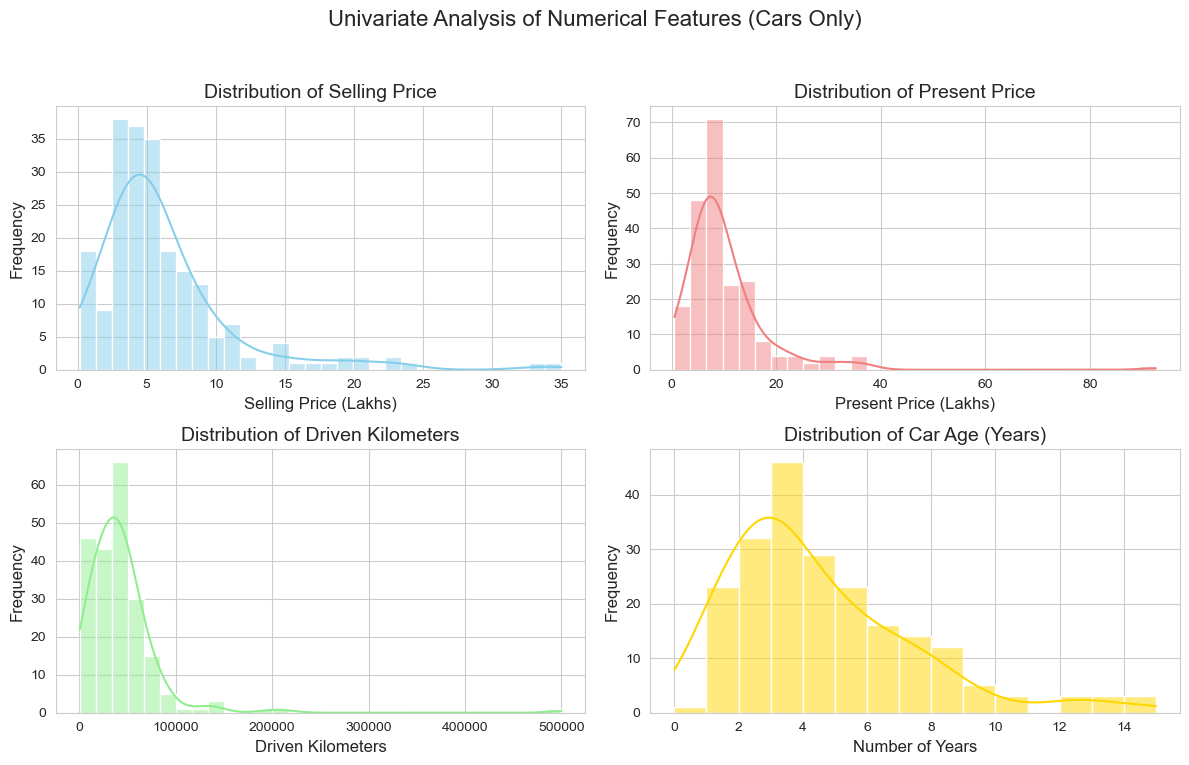

In [6]:
# Univariate Analysis (Individual Feature Distributions)
# Set a consistent visual style for plots for better aesthetics
sns.set_style("whitegrid")

# Histograms and KDE for numerical features
plt.figure(figsize=(12, 8))
# Corrected suptitle: "Univariate Analysis of Numerical Features"
plt.suptitle('Univariate Analysis of Numerical Features (Cars Only)', fontsize=16)

plt.subplot(2, 2, 1)
sns.histplot(df['Selling_Price'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Selling Price', fontsize=14)
plt.xlabel('Selling Price (Lakhs)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(2, 2, 2)
sns.histplot(df['Present_Price'], kde=True, bins=30, color='lightcoral')
plt.title('Distribution of Present Price', fontsize=14)
plt.xlabel('Present Price (Lakhs)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(2, 2, 3)
sns.histplot(df['Driven_kms'], kde=True, bins=30, color='lightgreen')
plt.title('Distribution of Driven Kilometers', fontsize=14)
plt.xlabel('Driven Kilometers', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(2, 2, 4)
sns.histplot(df['No_of_Years'], kde=True, bins=15, color='gold')
plt.title('Distribution of Car Age (Years)', fontsize=14)
plt.xlabel('Number of Years', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.savefig('univariate_numerical_distributions_cars_only.png')
plt.show()

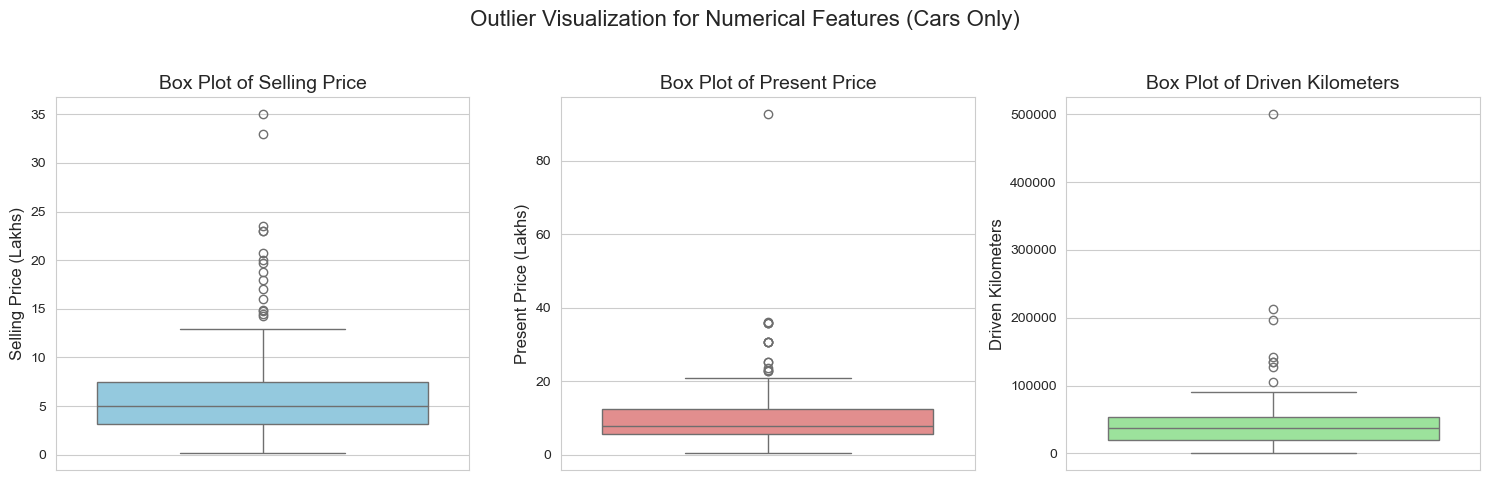

In [7]:
# Box plots for numerical features (for outlier visualization)
plt.figure(figsize=(15, 5))
plt.suptitle('Outlier Visualization for Numerical Features (Cars Only)', fontsize=16)

plt.subplot(1, 3, 1)
sns.boxplot(y=df['Selling_Price'], color='skyblue')
plt.title('Box Plot of Selling Price', fontsize=14)
plt.ylabel('Selling Price (Lakhs)', fontsize=12)
plt.subplot(1, 3, 2)
sns.boxplot(y=df['Present_Price'], color='lightcoral')
plt.title('Box Plot of Present Price', fontsize=14)
plt.ylabel('Present Price (Lakhs)', fontsize=12)

plt.subplot(1, 3, 3)
sns.boxplot(y=df['Driven_kms'], color='lightgreen')
plt.title('Box Plot of Driven Kilometers', fontsize=14)
plt.ylabel('Driven Kilometers', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('univariate_numerical_boxplots_cars_only.png')
plt.show()

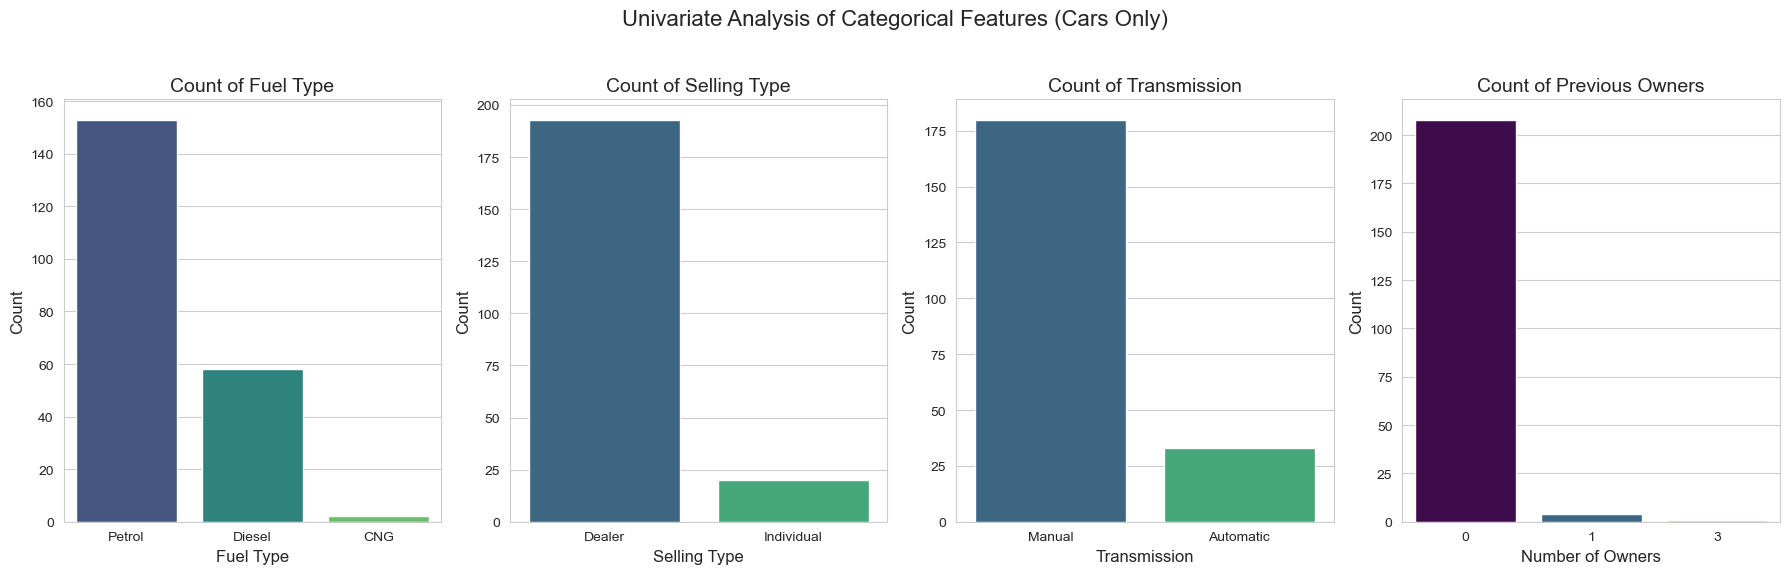

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

# --- Assuming 'df' is your DataFrame, for example: ---
# df = pd.read_csv('your_car_data.csv')


# Count plots for categorical features
plt.figure(figsize=(18, 6))
plt.suptitle('Univariate Analysis of Categorical Features (Cars Only)', fontsize=16)

plt.subplot(1, 4, 1)
# Corrected: Pass the DataFrame to 'data' and column names as strings
sns.countplot(x='Fuel_Type', hue='Fuel_Type', data=df, palette='viridis', legend=False)
plt.title('Count of Fuel Type', fontsize=14)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(1, 4, 2)
# Corrected: Pass the DataFrame to 'data' and column names as strings
sns.countplot(x='Selling_type', hue='Selling_type', data=df, palette='viridis', legend=False)
plt.title('Count of Selling Type', fontsize=14)
plt.xlabel('Selling Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(1, 4, 3)
# Corrected: Pass the DataFrame to 'data' and column names as strings
sns.countplot(x='Transmission', hue='Transmission', data=df, palette='viridis', legend=False)
plt.title('Count of Transmission', fontsize=14)
plt.xlabel('Transmission', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(1, 4, 4)
# Corrected: Pass the DataFrame to 'data' and column names as strings
sns.countplot(x='Owner', hue='Owner', data=df, palette='viridis', legend=False)
plt.title('Count of Previous Owners', fontsize=14)
plt.xlabel('Number of Owners', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('univariate_categorical_counts_cars_only.png')
plt.show() 

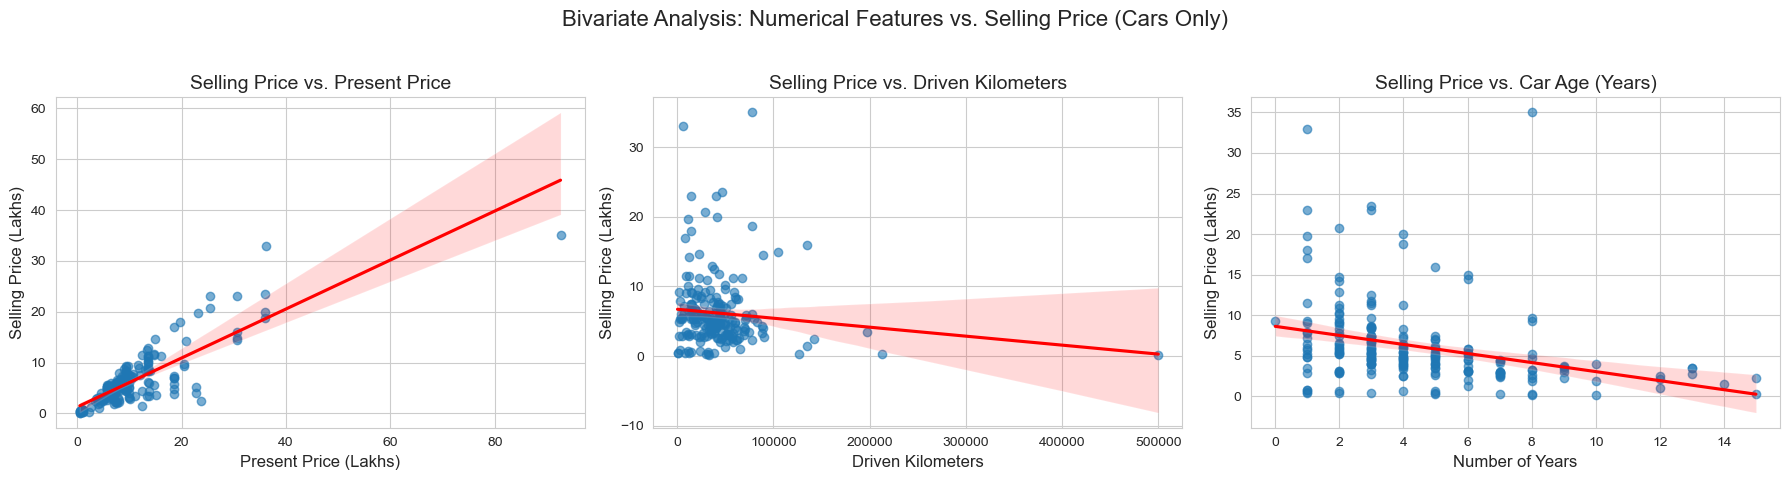

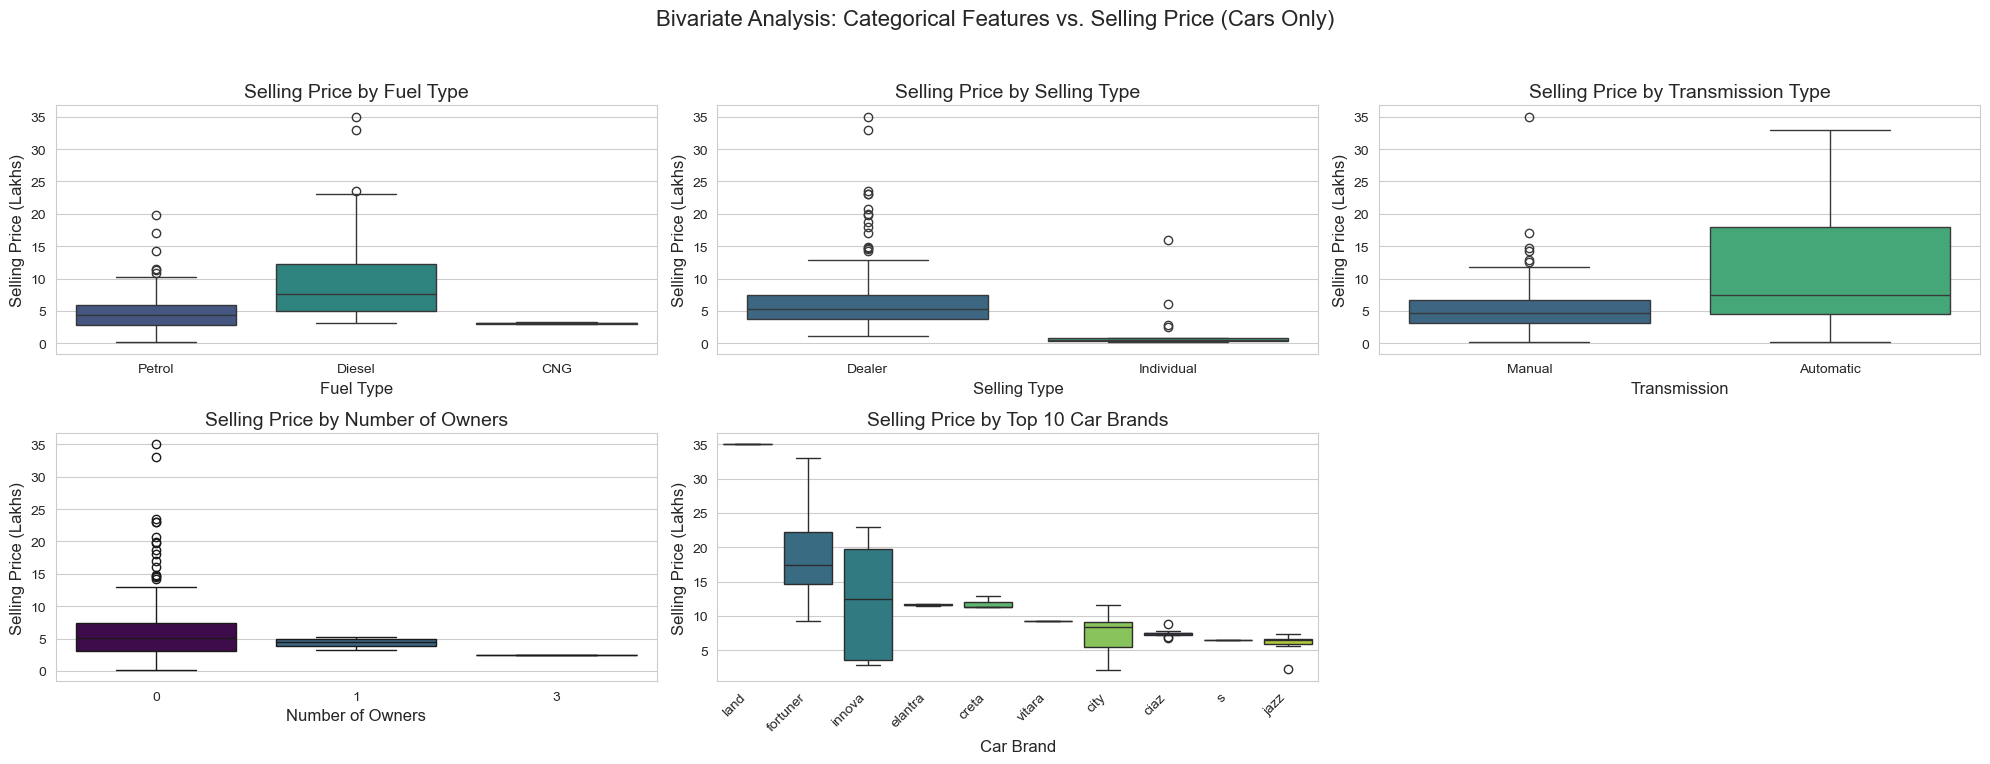

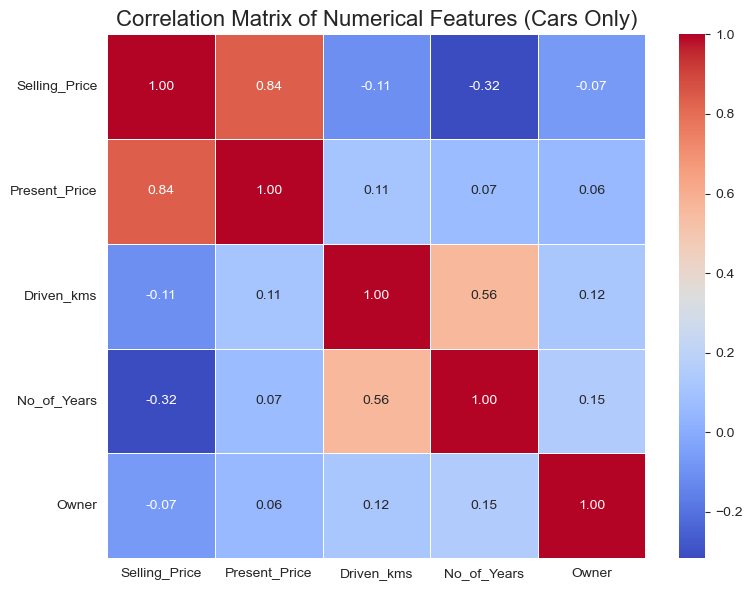

In [9]:
# Bivariate Analysis (Feature Relationships)
# We need to understand how each feature relates to the Selling_Price (our target) and how numerical features correlate with each other. Scatter plots with regression lines show trends for numerical vs. numerical, box plots show price variation across categorical groups, and a correlation heatmap quantifies linear relationships.These insights are vital for model feature selection
# Numerical Features vs. Selling_Price (Scatter Plots)
plt.figure(figsize=(18, 5))
plt.suptitle('Bivariate Analysis: Numerical Features vs. Selling Price (Cars Only)', fontsize=16)

plt.subplot(1, 3, 1)
sns.regplot(x='Present_Price', y='Selling_Price', data=df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Selling Price vs. Present Price', fontsize=14)
plt.xlabel('Present Price (Lakhs)', fontsize=12)
plt.ylabel('Selling Price (Lakhs)', fontsize=12)

plt.subplot(1, 3, 2)
sns.regplot(x='Driven_kms', y='Selling_Price', data=df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Selling Price vs. Driven Kilometers', fontsize=14)
plt.xlabel('Driven Kilometers', fontsize=12)
plt.ylabel('Selling Price (Lakhs)', fontsize=12)

plt.subplot(1, 3, 3)
sns.regplot(x='No_of_Years', y='Selling_Price', data=df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Selling Price vs. Car Age (Years)', fontsize=14)
plt.xlabel('Number of Years', fontsize=12)
plt.ylabel('Selling Price (Lakhs)', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('bivariate_numerical_scatterplots_cars_only.png')
plt.show() # Uncomment this line if you are running in a Jupyter Notebook to display plots

# Categorical Features vs. Selling_Price (Box Plots)
plt.figure(figsize=(20, 8))
plt.suptitle('Bivariate Analysis: Categorical Features vs. Selling Price (Cars Only)', fontsize=16)

plt.subplot(2, 3, 1)
# Using hue for boxplot as per FutureWarning
sns.boxplot(x='Fuel_Type', y='Selling_Price', data=df, hue='Fuel_Type', palette='viridis', legend=False)
plt.title('Selling Price by Fuel Type', fontsize=14)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Selling Price (Lakhs)', fontsize=12)

plt.subplot(2, 3, 2)
# Using hue for boxplot as per FutureWarning
sns.boxplot(x='Selling_type', y='Selling_Price', data=df, hue='Selling_type', palette='viridis', legend=False)
plt.title('Selling Price by Selling Type', fontsize=14)
plt.xlabel('Selling Type', fontsize=12)
plt.ylabel('Selling Price (Lakhs)', fontsize=12)

plt.subplot(2, 3, 3)
# Using hue for boxplot as per FutureWarning
sns.boxplot(x='Transmission', y='Selling_Price', data=df, hue='Transmission', palette='viridis', legend=False)
plt.title('Selling Price by Transmission Type', fontsize=14)
plt.xlabel('Transmission', fontsize=12)
plt.ylabel('Selling Price (Lakhs)', fontsize=12)

plt.subplot(2, 3, 4)
# Using hue for boxplot as per FutureWarning
sns.boxplot(x='Owner', y='Selling_Price', data=df, hue='Owner', palette='viridis', legend=False)
plt.title('Selling Price by Number of Owners', fontsize=14)
plt.xlabel('Number of Owners', fontsize=12)
plt.ylabel('Selling Price (Lakhs)', fontsize=12)

# For 'Brand', sort by median price and select top N for better readability
# Recalculate brand_median_prices on the filtered 'df'
brand_median_prices = df.groupby('Brand')['Selling_Price'].median().sort_values(ascending=False).index
top_brands = brand_median_prices[:10] # Display top 10 brands for clarity
df_top_brands = df[df['Brand'].isin(top_brands)]

plt.subplot(2, 3, 5)
# Using hue for boxplot as per FutureWarning
sns.boxplot(x='Brand', y='Selling_Price', data=df_top_brands, order=top_brands, hue='Brand', palette='viridis', legend=False)
plt.title('Selling Price by Top 10 Car Brands', fontsize=14)
plt.xlabel('Car Brand', fontsize=12)
plt.ylabel('Selling Price (Lakhs)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better fit

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('bivariate_categorical_boxplots_cars_only.png')
plt.show() # Uncomment this line if you are running in a Jupyter Notebook to display plots

# Correlation Matrix for numerical features
# 'Owner' is treated as a numerical column for correlation calculation.
numerical_cols = ['Selling_Price', 'Present_Price', 'Driven_kms', 'No_of_Years', 'Owner']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features (Cars Only)', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.savefig('numerical_correlation_heatmap_cars_only.png')
plt.show() 


In [10]:

#Encode Categorical Features
# Machine learning models require numerical input. Categorical features need to be converted. For nominal (unordered) categories, One-Hot Encoding is generally preferred over Label Encoding because it avoids implying an artificial ordinal relationship that doesn't exist in the data
# Identify categorical columns to encode (including 'Owner' as its distinct values behave categorically)
categorical_cols = ['Fuel_Type', 'Selling_type', 'Transmission', 'Owner', 'Brand']

# Apply One-Hot Encoding
# drop_first=True creates k-1 dummy variables for k categories, preventing multicollinearity issues.
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\nFirst 5 rows of the dataset after One-Hot Encoding:")
print(df_encoded.head())
print("\nInformation about the dataset after One-Hot Encoding (note the increased number of columns):")
print(df_encoded.info())
print(f"\nShape of the dataset after One-Hot Encoding: {df_encoded.shape}")



First 5 rows of the dataset after One-Hot Encoding:
   Selling_Price  Present_Price  Driven_kms  No_of_Years  Fuel_Type_Diesel  \
0           3.35           5.59       27000            4             False   
1           4.75           9.54       43000            5              True   
2           7.25           9.85        6900            1             False   
3           2.85           4.15        5200            7             False   
4           4.60           6.87       42450            4              True   

   Fuel_Type_Petrol  Selling_type_Individual  Transmission_Manual  Owner_1  \
0              True                    False                 True    False   
1             False                    False                 True    False   
2              True                    False                 True    False   
3              True                    False                 True    False   
4             False                    False                 True    False   

   Owner_

In [11]:
#Model Building & Evaluation
#This phase involves preparing the data for the model, training the chosen machine learning model, and rigorously assessing its performance

#Data Splitting
# To evaluate a model's performance on unseen data, it's critical to split the dataset into training and testing sets. 
#The training set is used to teach the model patterns, and the testing set is used to assess how well it generalizes. 
# A random_state is set to ensure reproducibility of the split

#*Action: Separate the features (independent variables, X) from the target variable (dependent variable, y, which is Selling_Price). 
 #Then, use train_test_split from sklearn.model_selection to divide X and y into training and testing sets

# Seperate features (X) and target (y)
X = df_encoded.drop('Selling_Price', axis=1) # All columns except 'Selling_Price' are features
y = df_encoded['Selling_Price'] # 'Selling_Price' is the target variable

print(f"Shape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")

# Split the data into 80% training and 20% testing sets

X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\n shape of X_train:{X_train}")
print(f"\n shape of X_test:{X_test}")
print(f"\n shape of y_train:{y_train}")
print(f"\n shape of y_test:{y_test}")



Shape of features (X): (213, 42)
Shape of target (y): (213,)

 shape of X_train:     Present_Price  Driven_kms  No_of_Years  Fuel_Type_Diesel  \
80           14.89       23000            2              True   
249           7.60       17000            2             False   
179           1.05      213000            8             False   
215           9.40       36100            6             False   
97           18.64        8700            1             False   
..             ...         ...          ...               ...   
173           0.51        1300            1             False   
14            7.21       77427            9             False   
94           22.78       89000           10             False   
267           9.40       19434            2              True   
140           1.20       32000            5             False   

     Fuel_Type_Petrol  Selling_type_Individual  Transmission_Manual  Owner_1  \
80              False                    False             

In [12]:
# Model selection

# Initialize the Random Forest Regressor model

rf_model= RandomForestRegressor(n_estimators=100 , random_state=42)

print("Training random forest regressor model" )

rf_model.fit(X_train , y_train)
print("model training comleted")

# Prediction on unseen test set
y_pred= rf_model.predict(X_test)

# Calculate various evaluation matrics to assess model performance
mae= mean_absolute_error(y_test , y_pred)
mse= mean_squared_error(y_test , y_pred)
rmse=np.sqrt(mse) #  square  of mse, providing errors in the original units
r2 = r2_score(y_test, y_pred) # R-squared score, indicating explained variance

print(f"\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f} Lakhs")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} Lakhs")
print(f"R-squared (R2) Score: {r2:.2f}")


Training random forest regressor model
model training comleted

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.76 Lakhs
Root Mean Squared Error (RMSE): 1.47 Lakhs
R-squared (R2) Score: 0.69


In [13]:
feature_importances = rf_model.feature_importances_
features = X.columns # Get the names of the features used in training
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Short feature by their importance in descending order
importance_df = importance_df.sort_values(by='Importance' , ascending=False)

print("\n Top 10 feature importances:")
print(importance_df.head(10))



 Top 10 feature importances:
                    Feature  Importance
0             Present_Price    0.849297
2               No_of_Years    0.102929
1                Driven_kms    0.023192
32               Brand_land    0.006420
16               Brand_city    0.004728
17            Brand_corolla    0.003657
6       Transmission_Manual    0.002012
30             Brand_innova    0.001768
3          Fuel_Type_Diesel    0.001594
5   Selling_type_Individual    0.001073


C:\Users\HP\AppData\Local\Temp\ipykernel_17864\3807525525.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis') # Plotting top 10 for better insight


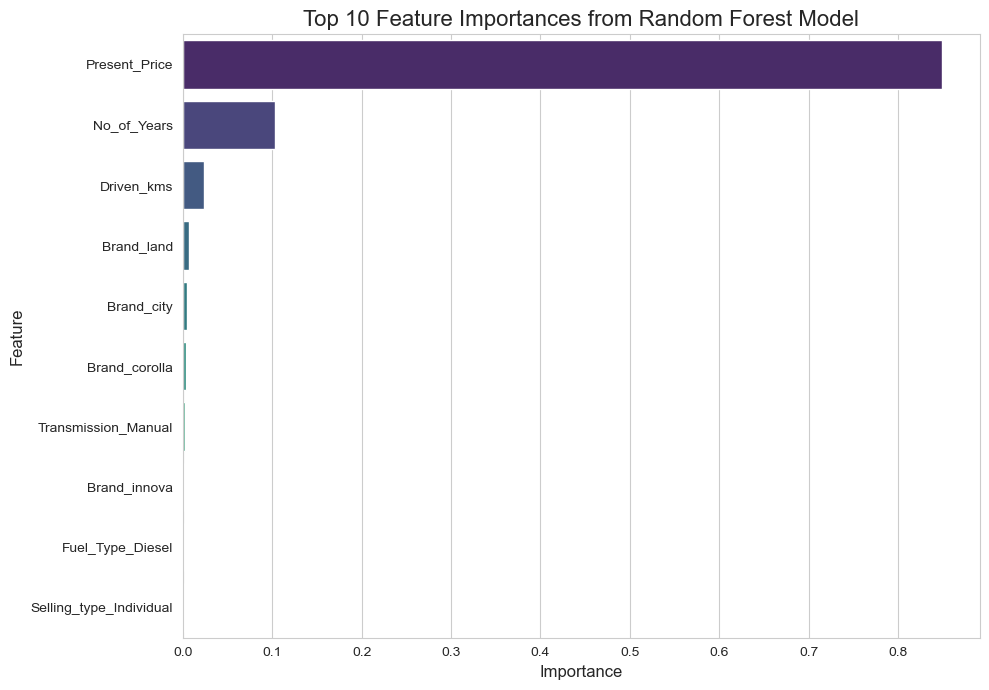

In [14]:
# Visualize feature importances using bar plot

plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis') # Plotting top 10 for better insight
plt.title('Top 10 Feature Importances from Random Forest Model', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.show() 

